In [1]:
using QuantumDynamics
using Plots
using LinearAlgebra

Hoping to get rid of the units issue by integrating Unitful into QuantumDynamics package.

In [2]:
const thz2au = 0.0001519828500716
const invcm2au = 4.55633e-6
const au2fs = 0.02418884254
const mev2invcm = 8.066
const angstrom2au = 1.8897268777744 # Not sure if this is the correct units for length
const au2cm = 5.29e-9

5.29e-9

In [3]:
struct fitsd <: SpectralDensities.AnalyticalSpectralDensity
    ωs :: Vector{Float64}
    jws :: Vector{Float64}
    ωmax :: Real
    Δs :: Real
    classical :: Bool
end

Gaussian broadening distribution

In [4]:
σ = 10*invcm2au
function evaluate(sd::fitsd, ω::Real)
    ωs = sd.ωs
    jws = sd.jws
    
    s = 0.0
    for i in 1:(size(ωs)[1])
        s += jws[i]*exp(-(((ω-ωs[i])/σ)^2))
    end
    s
end

evaluate (generic function with 1 method)

In [5]:
function discretize(sd::fitsd, num_osc::Int)
    return sd.ωs, (sd.jws.^(0.5))
end

discretize (generic function with 1 method)

In [6]:
(sd::fitsd)(ω::Real) = evaluate(sd, ω)

Ordejon paper mentions that Hamiltonian electronic terms are $\epsilon_0$ , $\epsilon_{AA+b}$ and $\epsilon_{AA+2b}$ for nearest 2 neighbours and additionally mentions that the coupling terms for nearest 2 neighbours on either side. Further mentions the couplings $\epsilon$AB, AC, AD for neighbours on the same unit cell. However, the value for $\epsilon_0$ (site energies) isn't mentioned in the paper? Perhaps worth doing some TD-DFT ourselves? Or alternatively some TrESP-ish method for 1-D... have to think about this for a bit

In [7]:
ϵ0 = -5000 * mev2invcm # This appears to not change the dynamics at all
ϵb = 134.0
ϵ2b = -10.7


site_distance = 7.15 * angstrom2au


13.51154717608696

In [8]:
N = 10

10

In [9]:
H0 = Matrix{ComplexF64}(zeros(N, N))

10×10 Matrix{ComplexF64}:
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im  …  0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im
 0.0+0.0im  0.0+0.0im  0.0+0.0im     0.0+0.0im  0.0+0.0im  0.0+0.0im

In [10]:
for i in 1:N
    H0[i,i] = ϵ0
    if i <= N-2
        H0[i, i+2] = ϵ2b
    end
    if i <= N-1
        H0[i, i+1] = ϵb
    end
    if i >= 2
        H0[i, i-1] = ϵb
    end
    if i>=3
        H0[i, i-2] = ϵ2b
    end
end

In [11]:
H0 = H0 * invcm2au

10×10 Matrix{ComplexF64}:
   -0.183757+0.0im  0.000610548+0.0im  …          0.0+0.0im
 0.000610548+0.0im    -0.183757+0.0im             0.0+0.0im
 -4.87527e-5+0.0im  0.000610548+0.0im             0.0+0.0im
         0.0+0.0im  -4.87527e-5+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im  …          0.0+0.0im
         0.0+0.0im          0.0+0.0im             0.0+0.0im
         0.0+0.0im          0.0+0.0im     -4.87527e-5+0.0im
         0.0+0.0im          0.0+0.0im     0.000610548+0.0im
         0.0+0.0im          0.0+0.0im       -0.183757+0.0im

In [12]:
ωp = [57.8, 59.6, 89.0, 107.3, 139.1, 639.1, 1011.2, 1344.7, 1593.3] .* invcm2au
ωpg0p = [-1.7, 1.4, 1.6, -0.14, -2.3, -7.5, -3.6, 19.8, -42.0] * invcm2au
g0p = ωpg0p ./ ωp
jws = (g0p.^(2))
wm = maximum(ωp)
Jw = fitsd(ωp, jws, wm, 1.0, false)

fitsd([0.000263355874, 0.00027155726800000003, 0.00040551337, 0.0004888942090000001, 0.000633785503, 0.002911950503, 0.004607360896, 0.006126896951000001, 0.007259600589], [0.0008650519031141869, 0.00055177694698437, 0.0003231915162226992, 1.7023804664001344e-6, 0.0002734018267790112, 0.00013771615591192445, 1.2674501281845861e-5, 0.00021681013046385349, 0.0006948698503452422], 0.007259600589, 1.0, false)

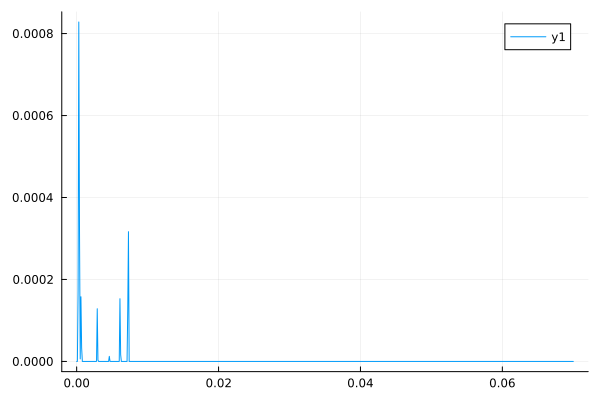

In [13]:
ω = 0:0.0001:0.07
plot(ω, Jw.(ω))

In [14]:
nsteps = 500
ρ0 = Matrix{ComplexF64}(zeros(N, N))
ρ0[5, 5] = 1

T = 50.0:50.0:500.0

β = 1 / (T[6] * 3.16683e-6) # T = 300K

1052.5772881188234

Simulation is very sensitive to time-stepping. NaNs get produced if you're not careful

In [15]:
dt = 20.0 # Around 0.5fs

20.0

In [16]:
fbU = Propagators.calculate_bare_propagators(; Hamiltonian=H0, dt=dt, ntimes=nsteps)    
t, ρ = TTM.propagate(; fbU=fbU, Jw=[Jw], β=β, ρ0=ρ0, dt=dt, ntimes=nsteps, rmax=1, extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.build_augmented_propagator)

(0.0:20.0:10000.0, [0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; 2.303261998813023e-13 + 0.0im -5.670267417847946e-12 + 7.187174600475284e-13im … 2.3031774326878857e-13 + 9.416296601927159e-19im -2.8072659339368844e-16 - 2.7740294877658165e-15im; … ; 0.0025608390632544968 - 0.002655825954718039im 0.02577980487867262 + 0.009294613581059822im … -0.0003288471364626639 - 0.02448288830332349im 0.02059870062368555 + 0.0010960170551478764im; 0.0028900360721812288 - 0.0026146179461791846im 0.025863367620484412 + 0.011328878530850217im … 0.000704715322394929 - 0.02544297424499832im 0.02048369680331762 + 0.0023500290271919982im;;; 0.0 + 0.0im 0.0 + 0.0im … 0.0 + 0.0im 0.0 + 0.0im; -5.670031471176354e-12 - 7.186875533464829e-13im 1.4183574163130702e-10 + 0.0im … -5.670056291106372e-12 - 7.187142531909699e-13im -1.7451274405927616e-15 + 6.916821504895991e-14im; … ; 0.02897538510776697 - 0.014943828379448644im 0.1591871088586352 - 0.0029593655124690557im … -0.01897327202602027 - 0.09673655405

In [61]:
## QCPI Run

ω, c = discretize(Jw, 100)
hb = Solvents.HarmonicBath(β, ω, c, [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0], 1000)
tc, ρc = QCPI.propagate(; Hamiltonian=H0, Jw, solvent=hb, ρ0, classical_dt=dt / 100, dt, ntimes=nsteps, kmax=1, svec=[1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0], extraargs=QuAPI.QuAPIArgs(), path_integral_routine=QuAPI.propagate)

LoadError: InterruptException:

HEOM only runs with Drude-Lorentz spectral densities...

In [138]:
## Running with HEOM

λs = repeat([35.0], N) * invcm2au
γs = 1 ./ (repeat([50.0], N) ./ au2fs)
JwD = Vector{SpectralDensities.DrudeLorentz}()
sys_ops = Vector{Matrix{ComplexF64}}()
for (j, (λ, γ)) in enumerate(zip(λs, γs))
    push!(JwD, SpectralDensities.DrudeLorentz(; λ, γ, Δs=1.0))
    op = zeros(N, N)
    op[j, j] = 1.0
    push!(sys_ops, op)
end

@time th, ρh = HEOM.propagate(; Hamiltonian=H0, ρ0=ρ0, Jw=JwD, β, ntimes=nsteps, dt, sys_ops, num_modes=2, Lmax=3, scaled=true, threshold=1e-10, extraargs=Utilities.DiffEqArgs(; reltol=1e-6, abstol=1e-6))

LoadError: InterruptException:

In [17]:
MSD = []
for i in 1:nsteps
    s = 0.0
    for j in 1:N
        s += real(ρ[i, j, j])*(site_distance*(j-5))^2
    end
    push!(MSD, s)
end

In [18]:
display("text/plain", MSD)

500-element Vector{Any}:
    0.0
    0.05583129333170834
    0.223325173323105
    0.502481639940407
    0.8933006930526592
    1.395782332319383
    2.009926557026671
    2.735733365859857
    3.5732027565974613
    4.522334725707644
    5.5831292678248134
    6.755586375080562
    8.03970603625923
    ⋮
 1128.8253471029195
 1126.5911037765752
 1124.4213934878776
 1122.3169101275744
 1120.2783396856676
 1118.3063591751932
 1116.4016355791887
 1114.5648248224222
 1112.796570769379
 1111.097504249948
 1109.4682421141767
 1107.909386317396

In [19]:
μ = β * (MSD[nsteps] - MSD[1])/((t[nsteps] - t[1])*au2fs)

4830.728257884739

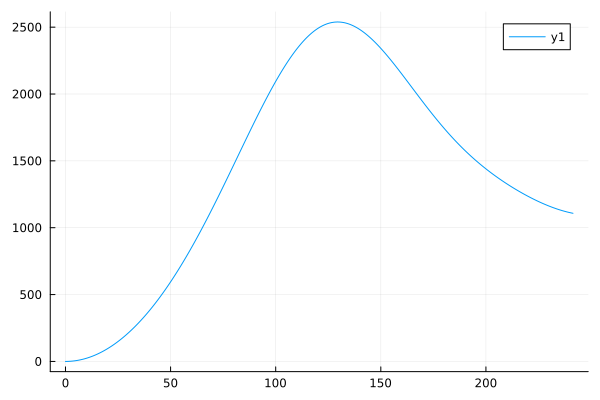

In [20]:
plot(t[1:nsteps].*au2fs, MSD, fmt= :png)

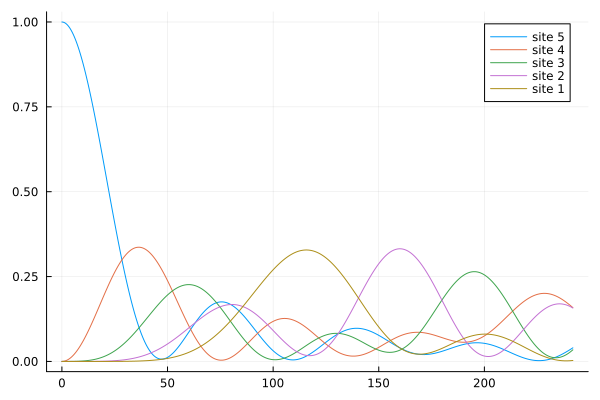

In [21]:
plot(t.*au2fs, real.(ρ[:, 5, 5]), label="site 5")
plot!(t.*au2fs, real.(ρ[:, 4, 4]), label="site 4")
plot!(t.*au2fs, real.(ρ[:, 3, 3]), label="site 3")
plot!(t.*au2fs, real.(ρ[:, 2, 2]), label="site 2")
plot!(t.*au2fs, real.(ρ[:, 1, 1]), label="site 1")

In [114]:
plot(th, real.(ρh[:, 5, 5]), label="site 5")
plot!(th, real.(ρh[:, 4, 4]), label="site 4")
plot!(th, real.(ρh[:, 3, 3]), label="site 3")
plot!(th, real.(ρh[:, 2, 2]), label="site 2")
plot!(th, real.(ρh[:, 1, 1]), label="site 1")

LoadError: UndefVarError: `th` not defined